In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd
import os
import mplleaflet
import OpticalRS
import numpy as np
import scipy as sp
from datetime import datetime as dt

in_data_dir = "/home/shares/scientist/sasap-biophys/HabitatMetrics/DEM/"
infp = lambda s: os.path.join(in_data_dir, s)
out_data_dir = os.path.expanduser("~/HabMetricsOut/")
outfp = lambda s: os.path.join(out_data_dir, s)

Populating the interactive namespace from numpy and matplotlib


/home/jkibele/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
if os.path.isdir(out_data_dir):
    print "Out data directory already exists."
else:
    !mkdir $out_data_dir
    print "Created out data directory."

Out data directory already exists.


We want to work with some shapefiles that are on the KNB. This function will let us read them without worrying about it to much.

In [3]:
import requests
import zipfile
import io

def geodataframe_from_zip_url(zip_url, tmp_dir="tmp_zip_asdfg333"):
    """
    Download a zipped shapefile to a temp directory, unzip it, read
    it into a geodataframe, and clean up the files. This function 
    will only work in a jupyter or ipython environment because it 
    makes calls to the shell (with `!`).
    """
    # prep temp dir by deleting, then creating
    if os.path.exists(tmp_dir):
        !rm -r $tmp_dir
    !mkdir $tmp_dir
    # download and extract
    r = requests.get(zip_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=tmp_dir)
    # get path to shp component of shapefile
    shp_fn = [shp for shp in os.listdir(tmp_dir) if shp.endswith('.shp')][0]
    # open geodataframe
    gdf = gpd.read_file(os.path.join(tmp_dir, shp_fn))
    # get rid of temp dir
    !rm -r $tmp_dir
    return gdf

### Yukon Elevation Problem

There are some erroneous large elevation values in the Yukon DEM. We'll find them and mask them.

In [4]:
alaska_yukon = infp('yukon_90dem.tif')

In [5]:
yukrds = OpticalRS.RasterDS(alaska_yukon)

In [6]:
%%time 
yukarr = yukrds.band_array

CPU times: user 2.8 s, sys: 1.73 s, total: 4.53 s
Wall time: 4.53 s


This describes, in numeric terms, what the problem is.

In [7]:
"The max elevation value is {} meters and there are {} pixels with that value.".format(
    yukarr.max(),
    (yukarr.flatten() == yukarr.max()).sum() )

'The max elevation value is 65535 meters and there are 18166 pixels with that value.'

Let's see where these erroneous values are. (We'll cap the color map at 5000 so we can still see the normal values)

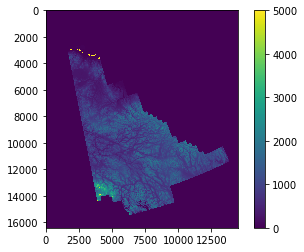

In [8]:
imshow(yukarr.squeeze(), vmax=5000)
colorbar()

Zooming in we see our issue:

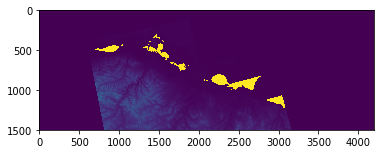

In [9]:
imshow(yukarr.squeeze()[2500:4000,1000:5200], vmax=5000)

Come up with a file path to write our results out to.

In [10]:
out_yuk = infp('yukon_90dem_fixed.tif')

Mask any erroneous data 40,0000 and above, set NoDataValue to 0

In [11]:
!gdal_calc.py -A $alaska_yukon --calc="((A>=40000)*0)+((A<40000)*A)" --outfile=$out_yuk --type='Int16' --NoDataValue=0 --overwrite

0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done


Display the result to make sure it's fixed.

In [12]:
yukrds = OpticalRS.RasterDS(out_yuk)
b = yukrds.band_array

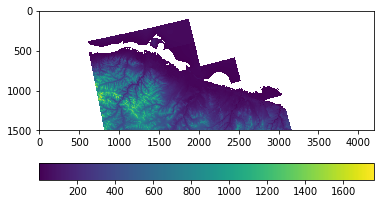

In [13]:
imshow(b.squeeze()[2500:4000,1000:5200])
colorbar(orientation='horizontal')

# Elevation

I need to attribute regions and watersheds with the following information:
* Mean elevation
* Minimum elevation
* Maximum elevation
* Median elevation
* Standard deviation of elevation
* Range of elevation
* Coefficient of variation of elevation

## Mosaic several DEMs

Now, I need to mosaic three DEMs in order to create a complete DEM for our regions of interest.
* `ak_dem_albers.tif` is a DEM for a region that covers roughly the state of Alaska.
* `bc_dem1.tif` is a DEM for a transboundary region between British Columbia and Alaska.
* `yukon_90dem_fixed.tif` is a DEM for a transboundary region between the Yukon and Alaska.

In [14]:
alaska_main = infp('ak_dem_albers.tif')
alaska_bc = infp('bc_dem1.tif') #no data value is -32768

I'll first make sure these DEMs are in the same projection. I'll start by defining output paths.

In [15]:
mosiac_dir = outfp('DEM_mosaic_3338')
if not os.path.isdir(mosiac_dir):
    !mkdir $mosiac_dir
    
alaska_main_3338 = outfp('DEM_mosaic_3338/ak_usa_3338.tif')
alaska_bc_3338 = outfp('DEM_mosaic_3338/alaska_bc_3338.tif')
alaska_yukon_3338 = outfp('DEM_mosaic_3338/alaska_yukon_3338.tif')


And use gdal to reproject each DEM.

In [16]:
!gdalwarp -t_srs EPSG:3338 -overwrite $alaska_main $alaska_main_3338

Creating output file that is 49563P x 39383L.
Processing input file /home/shares/scientist/sasap-biophys/HabitatMetrics/DEM/ak_dem_albers.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


I'll also mask "no data" values (value=0) in the AK state DEM so that I can successfully mosaic.

In [17]:
alaska_main_masked_3338 = outfp('DEM_mosaic_3338/ak_usa_masked_3338.tif')

In [18]:
!gdalwarp -srcnodata 0 -overwrite $alaska_main_3338 $alaska_main_masked_3338

Creating output file that is 49563P x 39383L.
Processing input file /home/jkibele/HabMetricsOut/DEM_mosaic_3338/ak_usa_3338.tif.
Copying nodata values from source /home/jkibele/HabMetricsOut/DEM_mosaic_3338/ak_usa_3338.tif to destination /home/jkibele/HabMetricsOut/DEM_mosaic_3338/ak_usa_masked_3338.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


I'll now repeat this process for Yukon and BC tiffs.

In [19]:
!gdalwarp -t_srs EPSG:3338 -srcnodata -32768 -dstnodata 0 -overwrite $alaska_bc $alaska_bc_3338

Creating output file that is 30387P x 27147L.
Processing input file /home/shares/scientist/sasap-biophys/HabitatMetrics/DEM/bc_dem1.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
!gdalwarp -overwrite -t_srs EPSG:3338 $out_yuk $alaska_yukon_3338

Creating output file that is 14489P x 16418L.
Processing input file /home/shares/scientist/sasap-biophys/HabitatMetrics/DEM/yukon_90dem_fixed.tif.
Using internal nodata values (e.g. 0) for image /home/shares/scientist/sasap-biophys/HabitatMetrics/DEM/yukon_90dem_fixed.tif.
Copying nodata values from source /home/shares/scientist/sasap-biophys/HabitatMetrics/DEM/yukon_90dem_fixed.tif to destination /home/jkibele/HabMetricsOut/DEM_mosaic_3338/alaska_yukon_3338.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


I'll check the pixel sizes of the reprojected rasters to see how they need to be resampled.

In [21]:
!gdalinfo $alaska_main_masked_3338 | grep Pixel
!gdalinfo $alaska_bc_3338 | grep Pixel
!gdalinfo $alaska_yukon_3338 | grep Pixel

Pixel Size = (61.111599999999996,-61.111599999999996)
Pixel Size = (95.005093625297974,-95.005093625297974)
Pixel Size = (90.000000000000128,-90.000000000000128)


Rasters should be resampled to the lowest resolution, roughly 95 meters for the BC tiff. I'll mosaic the DEMs using `gdal_merge`.

In [22]:
DEM_alaska = outfp('DEM_mosaic_3338/ak_all_regions_3338.tif')

In [23]:
if os.path.exists(DEM_alaska):
    !rm $DEM_alaska
!gdal_merge.py -n 0 -a_nodata 0 -ps 95.005093625297974 95.005093625297974 -o $DEM_alaska $alaska_bc_3338 $alaska_yukon_3338 $alaska_main_masked_3338

0...10...20...30...40...50...60...70...80...90...100 - done.


Plot the result to make sure it looks reasonable.

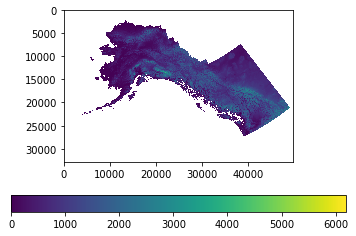

In [24]:
all_arr = OpticalRS.RasterDS(DEM_alaska).band_array
imshow(all_arr.squeeze())
colorbar(orientation='horizontal')

Make sure the pixel size is what we intended.

In [25]:
!gdalinfo $DEM_alaska | grep Pixel

Pixel Size = (95.005093625297974,-95.005093625297974)


## Regions

Using our mosaiced DEM, I want to attribute elevation statistics to regions of Alaska. First, I'll load the `regions` file and ensure it's in the Alaska Albers projection. I'll also convert our DEM into a numpy array using OpticalRS.

In [26]:
reg_url = 'https://knb.ecoinformatics.org/knb/d1/mn/v2/object/urn%3Auuid%3Af6ab206b-312c-4caf-89c8-89eb9d031aac'
regions = geodataframe_from_zip_url(reg_url).to_crs(epsg=3338)

In [27]:
%%time
rds = OpticalRS.RasterDS(DEM_alaska)
bandarr1 = rds.band_array

CPU times: user 15.5 s, sys: 8.76 s, total: 24.2 s
Wall time: 24.2 s


Make sure the max elevation is reasonable. According to Google, Mt. McKinley is 6190 meters, so I think 6182 is reasonable.

In [28]:
bandarr1.max()

6182

I'll write a function to calculate the summary statistics above from the elevation numpy array by each individual geometry. I'll first evaluate a sample geometry (the Yukon).

In [29]:
row = regions.iloc[5]

In [30]:
def stats_elev(rds, row):
    subarr = rds.geometry_subset(row.geometry)
    subarr_c = subarr.compressed()
    mean_arr = subarr_c.mean()
    max_arr = np.amax(subarr_c)
    min_arr = np.amin(subarr_c)
    median_arr = np.median(subarr_c)
    std_arr = np.std(subarr_c)
    coef_var_arr = std_arr/mean_arr
    range_arr = np.ptp(subarr_c)
    return [mean_arr, max_arr, min_arr, median_arr, std_arr, coef_var_arr, range_arr]

In [31]:
series = stats_elev(rds, row)
series

[309.61162095206635,
 2290,
 1,
 225.0,
 287.53327334386955,
 0.9286901843661258,
 2289]

That works well, so I'll apply all geometries in my `regions` GeoDataFrame through the same function.

In [32]:
def stats_elev_df(rds, gdf):
    new_series = gdf.apply(lambda r: stats_elev(rds, r), axis=1)
    return new_series

In [33]:
series2 = stats_elev_df(rds, regions)
series2

0     [225.40044343775523, 2835, 1, 123.0, 277.44683...
1     [390.502178761873, 2741, 1, 239.0, 427.9063977...
2     [246.14319787927988, 2813, 1, 132.0, 297.41904...
3     [286.8028087042826, 2506, 1, 203.0, 292.194061...
4     [1154.2552068907087, 5959, 1, 1012.0, 718.9032...
5     [309.61162095206635, 2290, 1, 225.0, 287.53327...
6     [297.82999522989127, 4481, 1, 210.0, 289.05299...
7     [291.83045991351855, 3371, 1, 194.0, 352.87690...
8     [779.4005279536891, 6182, 1, 746.0, 597.988149...
9     [212.96754195548573, 1401, 1, 175.0, 175.22149...
10    [699.6948250378579, 3994, 1, 540.0, 634.687535...
11    [944.8884765285009, 5951, -6, 950.0, 636.00654...
12    [683.5091521277717, 6177, 1, 625.0, 505.931237...
dtype: object

To turn this series of lists into a DataFrame, I'll use the `vstack` method, which takes a sequence of arrays and stacks them vertically to make a single array. I can then put this single array inside the DataFrame constructor. The final step is to attribute this data to the original regional shapefile (GeoDataFrame) using an attribute join in geopandas.

In [34]:
elev_regions = pd.DataFrame(np.vstack(series2), columns=["mean_elevation", "max_elevation", "min_elevation", "median_elevation","std_elevation", "coeff_var_elevation","range_elevation"])
elev_regions['region'] = regions.region
regions = regions.merge(elev_regions, on="region")
regions.drop('geometry', axis='columns')

,region_id,region,mean_elevation,max_elevation,min_elevation,median_elevation,std_elevation,coeff_var_elevation,range_elevation
0,1,Aleutian Islands,225.400443,2835.0,1.0,123.0,277.446837,1.230906,2834.0
1,2,Arctic,390.502179,2741.0,1.0,239.0,427.906398,1.095785,2740.0
2,3,Bristol Bay,246.143198,2813.0,1.0,132.0,297.419043,1.208317,2812.0
3,4,Chignik,286.802809,2506.0,1.0,203.0,292.194062,1.018798,2505.0
4,5,Copper River,1154.255207,5959.0,1.0,1012.0,718.903281,0.622829,5958.0
5,6,Kodiak,309.611621,2290.0,1.0,225.0,287.533273,0.928690,2289.0
6,7,Kotzebue,297.829995,4481.0,1.0,210.0,289.052991,0.970530,4480.0
7,8,Kuskokwim,291.830460,3371.0,1.0,194.0,352.876906,1.209185,3370.0
8,9,Cook Inlet,779.400528,6182.0,1.0,746.0,597.988149,0.767241,6181.0
9,10,Norton Sound,212.967542,1401.0,1.0,175.0,175.221490,0.822761,1400.0


In [35]:
regions.to_file(outfp('Regions_Elevation.shp'))
regions.drop('geometry', axis='columns').to_csv(outfp('Regions_Elevation.csv'))

## Watersheds

I'll repeat the subsetting process above for HUC8s. I want to assess the following for each watershed:
* Mean elevation
* Minimum elevation
* Maximum elevation
* Median elevation
* Standard deviation of elevation
* Range of elevation
* Coefficient of variation of elevation

I'm going get the watersheds directly from KNB.

In [36]:
huc_url = "https://knb.ecoinformatics.org/knb/d1/mn/v2/object/urn%3Auuid%3A19a8ac62-1681-4365-8804-fcaa65880615"
watersheds = geodataframe_from_zip_url(huc_url).to_crs(epsg=3338)

In [37]:
row = watersheds.iloc[5]

In [38]:
series = stats_elev(rds, row)
series

[496.5077890318404,
 2165,
 -4,
 434.0,
 373.76788776503105,
 0.7527936036891897,
 2169]

In [39]:
series2 = stats_elev_df(rds, watersheds)

In [40]:
elev_watersheds = pd.DataFrame(np.vstack(series2), columns=["mean_elevation", "max_elevation", "min_elevation", "median_elevation","std_elevation", "coeff_var_elevation","range_elevation"])
elev_watersheds['id_numeric'] = watersheds.id_numeric
watersheds = watersheds.merge(elev_watersheds, on="id_numeric")
watersheds.sort_values('max_elevation', ascending=False).head()

,id_numeric,name,id_origina,source,geometry,mean_elevation,max_elevation,min_elevation,median_elevation,std_elevation,coeff_var_elevation,range_elevation
38,19020504,Yentna River,19020504,IJC,"POLYGON ((170387.1288993187 1391194.911164923,...",823.801219,6182.0,6.0,688.0,664.278608,0.806358,6176.0
136,19080310,Kantishna River,19080310,IJC,"POLYGON ((209471.8702805945 1497901.047508167,...",577.118118,6177.0,77.0,336.0,592.124043,1.026001,6100.0
26,19020103,Chitina River,19020103,IJC,"POLYGON ((545518.912018616 1357307.467988569, ...",1642.122944,5959.0,143.0,1612.0,798.193488,0.486074,5816.0
22,19010405,Yakutat Bay-Gulf of Alaska,19010405,IJC,"POLYGON ((875092.2544799992 1115507.894661564,...",1105.424666,5951.0,-2.0,914.0,928.539031,0.839984,5953.0
36,19020502,Chulitna River,19020502,IJC,"(POLYGON ((198002.988873173 1377926.754576673,...",1080.776142,5724.0,90.0,1004.0,650.058519,0.601474,5634.0


In [41]:
watersheds.to_file(outfp('Watersheds_Elevation.shp'))
watersheds.drop('geometry', axis='columns').to_csv(outfp('Watersheds_Elevation.csv'))